## read data

In [36]:
import pandas as pd
import warnings
import json
warnings.filterwarnings('ignore')
Course=pd.read_excel('./data/course_clean.xlsx')
Course.dropna(inplace=True)
Course.Code=Course.Code.map(lambda x:x.replace(' ',''))
dic_a=dict(Course.Code)
my_dic = {k:v for v,k in dic_a.items()}
Course.head(1)

,Unnamed: 0,Track,Code,Unnamed: 2,Course Title,Instructor,Course Introduction,Course Introduction_Raw
0,0,FINTECH,ISFS614,ISFS614,Digital Banking & Trends,PATRICK THNG,financial services industry fsi undergoing tra...,The financial services industry (FSI) has been...


In [ ]:
# Course=pd.read_excel('Course.xlsx')
# Course.dropna(inplace=True)
# Course.Code=Course.Code.map(lambda x:x.replace(' ',''))
# dic_a=dict(Course.Code)
# my_dic = {k:v for v,k in dic_a.items()}
# Course.head(1)

In [37]:
JD=pd.read_excel('./data/jd_clean.xlsx')
print(JD.shape)
JD.head(1)

(8000, 14)


,Unnamed: 0,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName,FullDescription_Raw
0,0,12612628,Engineering Systems Analyst,engineering systems analyst dorking surrey sal...,"Dorking, Surrey, Surrey",Dorking,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 30000/annum 20-30K,25000,cv-library.co.uk,Engineering Systems Analyst Dorking Surrey Sal...


In [ ]:
# JD=pd.read_csv('Train_rev1.csv')
# JD=JD.head(6000)
# #JD=JD[JD['FullDescription'].str.contains('data')].reset_index(drop=True)
# JD.head(1)

## data process

In [ ]:
# import spacy
# nlp = spacy.load("en_core_web_sm")
# import string
# import re
# punc = set(string.punctuation)
# def tokenize(doc):
#     tokens = nlp(doc)
#     tokens=[token.lemma_ for token in tokens if token.is_stop==False]
#     tokens=[i for i in tokens if i not in punc]
#     tokens=[re.sub("[^A-Za-z]","", i) for i in tokens]#Remove non-alphabetic characters 
#     tokens=[i.lower() for i in tokens]
#     tokens=[i for i in tokens if i!='']
#     tokens=[i for i in tokens if len(i)>1]      
#     return tokens

In [ ]:
# # from pandarallel import pandarallel
# # pandarallel.initialize()
# Course['Text_Clean']=Course['Course Introduction'].map(lambda x:tokenize(x))
# JD['Text_Clean']=JD['FullDescription'].map(lambda x:tokenize(x))

In [38]:
Course.shape,JD.shape

((49, 8), (8000, 14))

In [ ]:
# #combine data
# data=pd.concat([Course[['Text_Clean']],JD[['Text_Clean']]],axis=0)
# data['Text_Clean2']=data['Text_Clean'].map(lambda x: " ".join(x))
# data

In [39]:
#combine data
Course['Text_Clean']=Course['Course Introduction']
JD['Text_Clean']=JD['FullDescription']
data=pd.concat([Course[['Text_Clean']],JD[['Text_Clean']]],axis=0)
data['Text_Clean2']=data['Text_Clean'].map(lambda x:x.split(' '))
data

,Text_Clean,Text_Clean2
0,financial services industry fsi undergoing tra...,"[financial, services, industry, fsi, undergoin..."
1,fintech creative integration emerging business...,"[fintech, creative, integration, emerging, bus..."
2,retail banking industry undergoing major trans...,"[retail, banking, industry, undergoing, major,..."
3,course explores corporate banking use smart co...,"[course, explores, corporate, banking, use, sm..."
4,financial institutions among intensive innovat...,"[financial, institutions, among, intensive, in..."
...,...,...
7995,qa test analyst york north yorkshire qa test a...,"[qa, test, analyst, york, north, yorkshire, qa..."
7996,marketing insight analyst sas direct marketing...,"[marketing, insight, analyst, sas, direct, mar..."
7997,database operations analyst batch database dev...,"[database, operations, analyst, batch, databas..."
7998,crm analyst client established yet constantly ...,"[crm, analyst, client, established, yet, const..."


In [40]:
data=data.reset_index(drop=True)#reset_index
data.to_csv('./data/data.csv',index=False)#save data

## Topic modeling 

In [41]:
import math
from gensim import corpora, models, similarities
import gensim
texts=data['Text_Clean2'].tolist()
dictionary = corpora.Dictionary(texts)
dictionary.filter_extremes(no_below=10, no_above=0.8)
corpus = [dictionary.doc2bow(text) for text in texts]
tfidf = gensim.models.TfidfModel(corpus=corpus,dictionary=dictionary)
corpus_tfidf = tfidf[corpus]

In [42]:
num_topics=6
best_model = models.ldamulticore.LdaMulticore(corpus_tfidf,num_topics=num_topics,id2word=dictionary,random_state=3)#lda model
#doc-topic
topic_list=[]
toppic_class=[]
toppic_proba=[]
for i in range(data.shape[0]):
    a=best_model.get_document_topics(corpus[i],minimum_probability=0)
    b=pd.DataFrame(a).sort_values(by=1,ascending=False).head(1)[0].values[0]
    c=pd.DataFrame(a).sort_values(by=1,ascending=False).head(1)[1].values[0]
    topic_list.append(a)
    toppic_class.append(b)
    toppic_proba.append(c)
data['topic']=topic_list
data['topic_class']=['topic'+str(i+1) for i in toppic_class]
data['topic_proba']=toppic_proba
for i in range(1,num_topics+1):
    data['topic'+str(i)]=data['topic'].map(lambda x: x[i-1][1])

In [ ]:
### 跑模型topic_number从1-15
from gensim.models.coherencemodel import CoherenceModel
perplexities = []
coherences = []
for topic_num in range(1, 15):
    print(topic_num)
    model = models.ldamulticore.LdaMulticore(corpus_tfidf,num_topics=topic_num,id2word=dictionary,random_state=3)
    perplexities.append(model.log_perplexity(corpus_tfidf))
    ldacm = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
    coherences.append(ldacm.get_coherence())

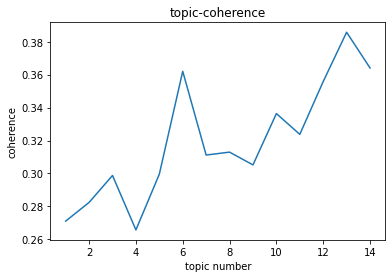

In [32]:
### 画图：coherence
import matplotlib.pyplot as plt
import matplotlib
x = range(1,15)
y = [coherences[i-1] for i in x]
plt.plot(x, y)
plt.xlabel('topic number')
plt.ylabel('coherence')
plt.rcParams['font.sans-serif']=['SimHei']
matplotlib.rcParams['axes.unicode_minus']=False
plt.title('topic-coherence')
plt.show()

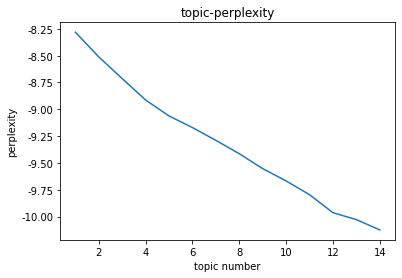

In [43]:
### 画图：perplexity
import matplotlib.pyplot as plt
import matplotlib
x = range(1,15)
y = [perplexities[i-1] for i in x]
plt.plot(x, y)
plt.xlabel('topic number')
plt.ylabel('perplexity')
plt.rcParams['font.sans-serif']=['SimHei']
matplotlib.rcParams['axes.unicode_minus']=False
plt.title('topic-perplexity')
plt.show()

In [50]:
### 读进csv文件里
import pandas as pd
df = pd.DataFrame(columns=['topic_number','perplexity', 'coherence'])
df['topic_number'] = range(1, 15)
df['perplexity'] = perplexities
df['coherence'] = coherences
df.to_csv('perplexity-coherence.csv', index=False)
# df.head()

In [44]:
import pandas  as pd
word_num=20
result=pd.DataFrame(best_model.print_topics(num_topics,word_num))
result[1]=result[1].map(lambda x:x.split('+'))
for i in range(word_num):
    result['word'+str(i+1)]=result[1].map(lambda x:x[i])
del result[1]
del result[0]
result=result.T
result.columns=['topic'+str(i+1) for i in result.columns.tolist()]
for i in result.columns.tolist():
    result[i+'-keyword']=result[i].map(lambda x:x.split('*')[-1].replace('"','').strip())
    result[i+'-weight']=result[i].map(lambda x:x.split('*')[0])
    del result[i]
result.to_csv('topic-word.csv')
result

,topic1-keyword,topic1-weight,topic2-keyword,topic2-weight,topic3-keyword,topic3-weight,topic4-keyword,topic4-weight,topic5-keyword,topic5-weight,topic6-keyword,topic6-weight
word1,sql,0.005,sales,0.007,hr,0.016,test,0.006,data,0.004,marketing,0.005
word2,database,0.005,planner,0.006,generalist,0.005,marketing,0.005,hr,0.004,data,0.004
word3,repair,0.004,media,0.005,sales,0.004,digital,0.005,ecommerce,0.003,analyst,0.003
word4,server,0.004,jobs,0.005,partner,0.004,europe,0.004,sql,0.003,analysis,0.003
word5,data,0.004,digital,0.005,bp,0.003,sales,0.004,analyst,0.003,travel,0.003
word6,dynamics,0.003,subscription,0.004,er,0.003,agencies,0.004,graduate,0.002,sas,0.003
word7,partners,0.003,data,0.004,reward,0.003,publishing,0.004,social,0.002,financial,0.002
word8,support,0.003,manager,0.003,people,0.003,new,0.003,requirements,0.002,sap,0.002
word9,systems,0.003,marketing,0.003,managers,0.002,testing,0.003,systems,0.002,direct,0.002
word10,service,0.003,linkedin,0.003,senior,0.002,european,0.003,developer,0.002,pelican,0.002


In [ ]:
# print doc-topic
data[['topic_class','topic_proba']+['topic'+str(i) for i in range(1,num_topics+1)]]

,topic_class,topic_proba,topic1,topic2,topic3,topic4,topic5,topic6
0,topic6,0.572039,0.145087,0.001519,0.001520,0.078112,0.201722,0.572039
1,topic5,0.920655,0.072321,0.001755,0.001756,0.001755,0.920655,0.001758
2,topic6,0.843085,0.001258,0.001258,0.001258,0.001259,0.151882,0.843085
3,topic6,0.854405,0.001817,0.001816,0.110535,0.001816,0.029611,0.854405
4,topic6,0.992262,0.001549,0.001545,0.001549,0.001546,0.001548,0.992262
...,...,...,...,...,...,...,...,...
8044,topic4,0.817793,0.000947,0.000947,0.022921,0.817793,0.156445,0.000947
8045,topic6,0.993263,0.001348,0.001347,0.001347,0.001347,0.001348,0.993263
8046,topic1,0.992829,0.992829,0.000946,0.000946,0.000945,0.003381,0.000954
8047,topic6,0.664077,0.005193,0.299654,0.000818,0.000818,0.029439,0.664077


In [ ]:
data[['topic_class','topic_proba']+['topic'+str(i) for i in range(1,num_topics+1)]].to_csv('doc-topic.csv',index=False)

In [35]:
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis
pyLDAvis.enable_notebook()
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
d=gensimvis.prepare(best_model, corpus_tfidf, dictionary)
pyLDAvis.display(d)

ModuleNotFoundError: ignored

In [34]:
pyLDAvis.save_html(d, 'lda_View.html')

NameError: ignored

## calculate similarity

In [23]:
tdidf_doc=data[['topic'+str(i) for i in range(1,num_topics+1)]].values
tdidf_doc[0]

array([0.01902783, 0.07847328, 0.00151809, 0.00151994, 0.0846932 ,
       0.81476766], dtype=float32)

In [14]:
Course_doc=tdidf_doc[:Course.shape[0]]
Jd_doc=tdidf_doc[Course.shape[0]:]

In [15]:
Course_doc.shape,Jd_doc.shape

((49, 6), (8000, 6))

In [16]:
from scipy.stats import entropy
def jensen_shannon(query, matrix):
    """
    This function implements a Jensen-Shannon similarity
    between the input query (an LDA topic distribution for a document)
    and the entire corpus of topic distributions.
    It returns an array of length M where M is the number of documents in the corpus
    """
    # lets keep with the p,q notation above
    p = query[None,:].T # take transpose
    q = matrix.T # transpose matrix
    m = 0.5*(p + q)
    return np.sqrt(0.5*(entropy(p,m) + entropy(q,m)))

In [17]:
def get_most_similar_documents(query,matrix,k=20):
    """
    This function implements the Jensen-Shannon distance above
    and retruns the top k indices of the smallest jensen shannon distances
    """
    sims = jensen_shannon(query,matrix) # list of jensen shannon distances
    return sims.argsort()[:k],sims[sims.argsort()[:k]] # the top k positional index of the smallest Jensen Shannon distances

In [18]:
# this is surprisingly fast
import numpy as np
dic_a=dict(Course['Course Title'])
my_dic2 = {k:v for v,k in dic_a.items()}
def calculate_sim(Course_id,flag=1):
    if flag==1:
        index_list=[]
        for i in Course_id:
            index_list.append(my_dic[i])
        most_sim_ids,most_sim_values = get_most_similar_documents(Course_doc[np.array(index_list)].mean(axis=0),Jd_doc)
    else:
        index_list=[]
        for i in Course_id:
            index_list.append(my_dic2[i])
        most_sim_ids,most_sim_values = get_most_similar_documents(Course_doc[np.array(index_list)].mean(axis=0),Jd_doc)
    return most_sim_ids,most_sim_values

In [19]:
#Course_id list
my_dic.keys()

dict_keys(['ISFS614', 'ISFS621', 'ISFS602', 'ISFS603', 'ISFS605', 'ISFS610', 'ISFS620', 'ISFS622', 'ISFS623', 'ISFS624', 'IS615', 'IS620', 'IS621', 'IS622', 'IS623', 'IS624', 'IS625', 'ISSS622', 'ISSS621', 'ISSS602', 'ISSS603', 'ISSS604', 'ISSS612', 'ISSS608', 'ISSS609', 'ISSS606', 'CS610', 'ISSS611', 'ISSS615', 'ISSS616', 'ISSS623', 'ISSS624', 'CS609', 'CS601', 'CS602', 'CS603', 'CS604', 'CS606', 'CS605', 'CS608', 'CS611', 'CS612', 'IS613', 'IS602', 'IS603', 'IS604', 'IS614', 'IS619'])

In [20]:
print('input Course_id')
print('return JD top20')
c=['ISSS602', 'ISSS622', 'ISSS616','ISSS621']
index_list1=calculate_sim(c,flag=1)[0]
value_list1=calculate_sim(c,flag=1)[1]
result=JD[JD.index.isin(index_list1)]
result['sim_values']=value_list1
print(c)
print(result.shape)
result.to_excel(" ".join(c)+'.xlsx')
result

input Course_id
return JD top20
['ISSS602', 'ISSS622', 'ISSS616', 'ISSS621']
(20, 16)


,Unnamed: 0,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName,FullDescription_Raw,Text_Clean,sim_values
232,5974,62116649,Statistician Analyst,world leading financial services client surrey...,UK,UK,full_time,permanent,Byron Finance,Accounting & Finance Jobs,"From 37,500 to 40,000 per year",38750,fish4.co.uk,Our world leading financial services client in...,world leading financial services client surrey...,0.033304
598,14214,66699540,Compliance Monitoring Analyst,key responsibilitiesworking monitoring team ca...,London,London,NaN,NaN,Not disclosed,Accounting & Finance Jobs,"50,000 - 60,000 + Benefits",55000,eFinancialCareers,Key ResponsibilitiesWorking with the monitorin...,key responsibilitiesworking monitoring team ca...,0.048818
937,19502,67101340,Senior Finance Analyst,senior financial analyst global market leader ...,Berkshire,Berkshire,full_time,contract,Investigo,Accounting & Finance Jobs,From 300 to 350 per day,78000,GAAPweb,Senior Financial Analyst Global Market Leader ...,senior financial analyst global market leader ...,0.081086
1281,25958,67779480,Senior Business Partner,role title senior finance business partner eur...,London,London,full_time,permanent,Hays Senior Finance,Accounting & Finance Jobs,"From 55,000 to 70,000 per year",62500,GAAPweb,"Role Title: Senior Finance Business Partner, E...",role title senior finance business partner eur...,0.085583
2240,40059,68359223,Business Analyst,business analyst required work major insurer b...,Surrey South East,Surrey,NaN,permanent,Strategic ICT Recruitment Solutions,IT Jobs,35000 - 50000 per annum + Excellent benefits,42500,cwjobs.co.uk,Business Analyst Required to work for Major In...,business analyst required work major insurer b...,0.088188
3143,52402,68667909,Senior Business Analyst,jo senior business analyst bradford client rec...,Bradford West Yorkshire Yorkshire,Bradford,NaN,permanent,Charterhouse Recruitment,Retail Jobs,"From 40,000 to 40,000 per annum",40000,totaljobs.com,JO**** Senior Business Analyst Bradford Our cl...,jo senior business analyst bradford client rec...,0.091688
3635,57347,68685112,Planning & Forecasting Analyst,company client global company representing dif...,West London London South East,East Sheen,NaN,permanent,Robert Half Hammersmith,Accounting & Finance Jobs,45000 - 60000 per annum,52500,totaljobs.com,The Company My client is a global company repr...,company client global company representing dif...,0.102772
3756,58703,68688853,Finance Business Partner,client reputable recognisable service provider...,Lancashire North West,Lancashire,NaN,permanent,Sellick Partnership,Accounting & Finance Jobs,30000 - 35000 per annum,32500,totaljobs.com,Our client is a reputable and recognisable ser...,client reputable recognisable service provider...,0.103387
3874,60019,68692431,Data Integration Executive (6 month contract),exciting opportunity graduate calibre individu...,Bracknell Berkshire South East,Bracknell,NaN,permanent,Bucks & Berks Recruitment PLC,Admin Jobs,20000 - 21000 per annum,20500,totaljobs.com,Exciting opportunity for a graduate calibre in...,exciting opportunity graduate calibre individu...,0.104433
4214,63684,68704793,Corporate Credit Risk Analyst,amazing opportunity recently become available ...,London South East,South East London,NaN,permanent,LMA Recruitment,Accounting & Finance Jobs,"From 45,000 to 55,000 per annum",50000,totaljobs.com,An amazing opportunity has recently become ava...,amazing opportunity recently become available ...,0.104586


In [21]:
#Course_id list
my_dic2.keys()

dict_keys(['Digital Banking & Trends ', 'Fintech Innovations & Start-ups ', 'Digital Transformation in Retail Banking Technology ', 'Corporate Banking & Blockchain ', 'Financial Markets Systems & Technology ', 'Digital Payments & Innovations ', 'Data Science in Financial Services ', 'Quantum Computing in Financial Services ', 'Risktech and Regtech ', 'NFT & CBDC Technology (0.5CU) ', 'Digital Transformation Strategy (SMU-X) ', 'Digital Organization & Change Management ', 'Agile & DevSecOps ', '(digital) Product Management ', 'Digital Governance & Risk Management ', 'Experimental Learning & Design Thinking ', 'Digital Enterprise Architecture ', 'Python Programming and Data Analysis & ', 'Data Science for Business ', 'Data Analytics Lab ', 'Customer Analytics & Applications (SMU-X) ', 'Operations Analytics & Applications ', 'Big Data: Tools & Techniques ', 'Visual Analytics & Applications ', 'Text Analytics & Applications ', 'Social Analytics & Applications ', 'Applied Machine Learning '

In [22]:
from tabulate import tabulate
print('input Course_title')
print('return JD top20')
c= ['Digital Banking & Trends ', 'Big Data: Tools & Techniques ', 'Digital Transformation in Retail Banking Technology ', 'Corporate Banking & Blockchain ', 'Financial Markets Systems & Technology ']
index_list1=calculate_sim(c,flag=0)[0]
value_list1=calculate_sim(c,flag=0)[1]
result=JD[JD.index.isin(index_list1)]
result['sim_values']=value_list1
print(c)
print(result.shape)
#     print(tabulate(result, headers='keys', tablefmt='psql'))
#     print(result)
result.to_excel(" ".join(c)+'.xlsx')
result

input Course_title
return JD top20
['Digital Banking & Trends ', 'Big Data: Tools & Techniques ', 'Digital Transformation in Retail Banking Technology ', 'Corporate Banking & Blockchain ', 'Financial Markets Systems & Technology ']
(20, 16)


,Unnamed: 0,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName,FullDescription_Raw,Text_Clean,sim_values
621,14775,66744213,Data Manager,data manager data collection market research t...,Tadcaster,Tadcaster,full_time,NaN,Sky High Traffic Data,Admin Jobs,"25,000.00 - 40,000.00 per year",32500,Jobcentre Plus,Data Manager Data Collection/Market Research/T...,data manager data collection market research t...,0.073393
641,15860,66773714,Refinery Planning Scheduling Optimisation Analyst,client oil major based london hiring optimisat...,London,London,full_time,permanent,Longbridge Recruitment Limited,IT Jobs,"From 50,000 to 65,000 per year",57500,planetrecruit.com,Our client is an oil major based in London. Fo...,client oil major based london hiring optimisat...,0.081500
768,17510,66925936,Head of Business Improvement and IT (Charity) ...,head business improvement charity k compassion...,"Godalming, Surrey",Godalming,NaN,permanent,EasyWeb Recruitment,IT Jobs,38000 - 41000/annum,39500,cv-library.co.uk,Head of Business Improvement and IT (Charity) ...,head business improvement charity k compassion...,0.088283
810,18261,66983449,Senior Commercial Analyst,exciting opportunity arisen hardworking commit...,West London London South East,East Sheen,NaN,contract,QVC Ltd,Retail Jobs,"From 34,000 to 43,000 per annum Pension, Priva...",38500,retailchoice.com,An exciting opportunity has arisen for a Hardw...,exciting opportunity arisen hardworking commit...,0.091433
882,19236,67099444,Financial Analyst,role give successful applicant tremendous insi...,London,London,full_time,permanent,Holden Jones Financial Recruitment,Accounting & Finance Jobs,"From 36,000 to 45,000 per year",40500,GAAPweb,This role will give the successful applicant a...,role give successful applicant tremendous insi...,0.114935
1300,26520,67804467,Credit Analysts at the Junior and Senior Level,bunker fuel shipping firm credit analysts juni...,Greater London,London,NaN,NaN,Selby Jennings,Other/General Jobs,"50,000-74,999 yearly",62499,theladders.co.uk,Bunker Fuel and Shipping Firm | Credit Analyst...,bunker fuel shipping firm credit analysts juni...,0.116303
1952,36091,68242001,Financial Analyst,international business based welwyn garden cit...,Hertfordshire,Hertfordshire,full_time,permanent,Accountancy Action Ltd,Accounting & Finance Jobs,"From 40,000 to 45,000 per year",42500,GAAPweb,International business based in Welwyn Garden ...,international business based welwyn garden cit...,0.120931
3672,57654,68685977,"Energy Data Analyst, BMSi British Gas",energy data analyst bmsi british gas overview ...,Berkshire South East,Berkshire,NaN,permanent,British Gas,"Energy, Oil & Gas Jobs",23000 - 27000,25000,totaljobs.com,"Energy Data Analyst, BMSi British Gas; Overvi...",energy data analyst bmsi british gas overview ...,0.121933
3757,58720,68688901,Business Analyst,grafton banks finance currently looking either...,Middlesex South East,UK,NaN,permanent,Grafton Banks,Accounting & Finance Jobs,"40k - 50k per year + Pension, healthcare",45000,totaljobs.com,Grafton Banks Finance is currently looking for...,grafton banks finance currently looking either...,0.122747
3906,60445,68693523,PRICING ANALYST,pricing analyst rapidly growing successful int...,South West London London South East,East Sheen,NaN,permanent,C&M Recruitment,Travel Jobs,28000.00 per annum,28000,totaljobs.com,PRICING ANALYST This rapidly growing and succ...,pricing analyst rapidly growing successful int...,0.124150
